In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [2]:
from models_explainability.ExplainableModels import ExplainableModel
from models_explainability.agreement import attributions_preprocessing
import os
from matplotlib import pyplot as plt
import matplotlib as mtpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
from typing import List
import numpy as np

/home/srepetto/miniconda3/envs/XAI-for-Healthcare/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/srepetto/miniconda3/envs/XAI-for-Healthcare/lib/python3.12/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/home/srepetto/miniconda3/envs/XAI-for-Healthcare/lib/python3.12/site-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)


In [3]:
new_cwd = os.path.join(os.getcwd(), "models_explainability")
os.chdir(new_cwd)
print("working in: ",os.getcwd())

working in:  /data/srepetto/XAI-for-Healthcare-paper_version/models_explainability


In [4]:
#parameters inizialitation
model_name = 'resnet50'
train_data_name = 'dermamnist'
data_name = 'dermamnist'
n_classes = 7
algorithm ='DeepLift'
batch_size = 64
dataset_subset_size = 10
ε = 2 

In [5]:
##load model
model = ExplainableModel(model_name = model_name,
                                        train_data_name = train_data_name,
                                        n_classes = n_classes)

loading:../models_training/resnet50/output/dermamnist/checkpoint_best.pth


/data/srepetto/XAI-for-Healthcare-paper_version/models_explainability/ExplainableModels.py:251: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_model = torch.load(m

In [6]:
##load data
data_clean=ExplainableModel.load_data(data_name=data_name,
                                        data_split="test")

Dataset dermamnist split test loaded


In [7]:
##load attributions
attributions_clean = model.explain_dataset(algorithm=algorithm,
                        data_name=data_name,
                        data_split="test", batch_size=batch_size,)

Dataset dermamnist split test loaded


Explaining batch of images using DeepLift:   0%|          | 0/32 [00:00<?, ?it/s]

/home/srepetto/miniconda3/envs/XAI-for-Healthcare/lib/python3.12/site-packages/captum/attr/_core/deep_lift.py:304: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(
Explaining batch of images using DeepLift: 100%|██████████| 32/32 [00:36<00:00,  1.14s/it]


In [15]:
##run the attack
model.attack(algorithm=algorithm,
                data_name=data_name,
                batch_size=batch_size,
                dataset_subset_size=dataset_subset_size,
                ε=ε)

Adversarial examples for DeepLift already exist, skipping attack
Adversarial explanations for DeepLift already exist, skipping attack


In [9]:
##load adversarial examples
adversarial_examples = ExplainableModel.load_adversarial_examples(algorithm=algorithm,
                                                                        model_name=model_name,
                                                                        train_data_name=data_name,
                                                                        data_name=data_name,
                                                                        ε=ε)

In [10]:
##load adversarial explanations
adversarial_explanations = ExplainableModel.load_adversarial_explanations(algorithm=algorithm,
                                                                                model_name=model_name,
                                                                                train_data_name=data_name,
                                                                                data_name=data_name,
                                                                                ε=ε)

In [11]:
def plot(imgs: List[np.ndarray]):
    titles = [r'$\boldsymbol{x}$', 
                r'$\mathcal{I}(\boldsymbol{x},f)$',
                r'$\boldsymbol{x}_{\text{adv}}$',
                r'$\mathcal{I}(\boldsymbol{x}_{\text{adv}}, f)$']

    fig, axs = plt.subplots(1, 4, figsize=(20, 10), constrained_layout=False)  # Ensures equal sizes
    fig.subplots_adjust(wspace=0.2, hspace=0.2)  # Adjust spacing between images

    for i, (ax, img, title) in enumerate(zip(axs, imgs, titles)):
        ax.patch.set_edgecolor('black')
        ax.patch.set_linewidth(3)
        #print(title)
        ax.set_title(title, fontsize=26, pad=12)
        im = ax.imshow(img, cmap="terrain")

        # Create a divider for each image to ensure colorbars don’t affect sizing
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="3%", pad=0.15)  

        if i % 2 != 0:  # Add colorbar only to odd images
            cbar = fig.colorbar(im, cax=cax, orientation='vertical')
            cbar.ax.tick_params(labelsize=16)  # Adjust tick label size if needed
            
        else:
            cax.remove()  # Remove extra space for even images

        ax.set_xticks([])
        ax.set_yticks([])

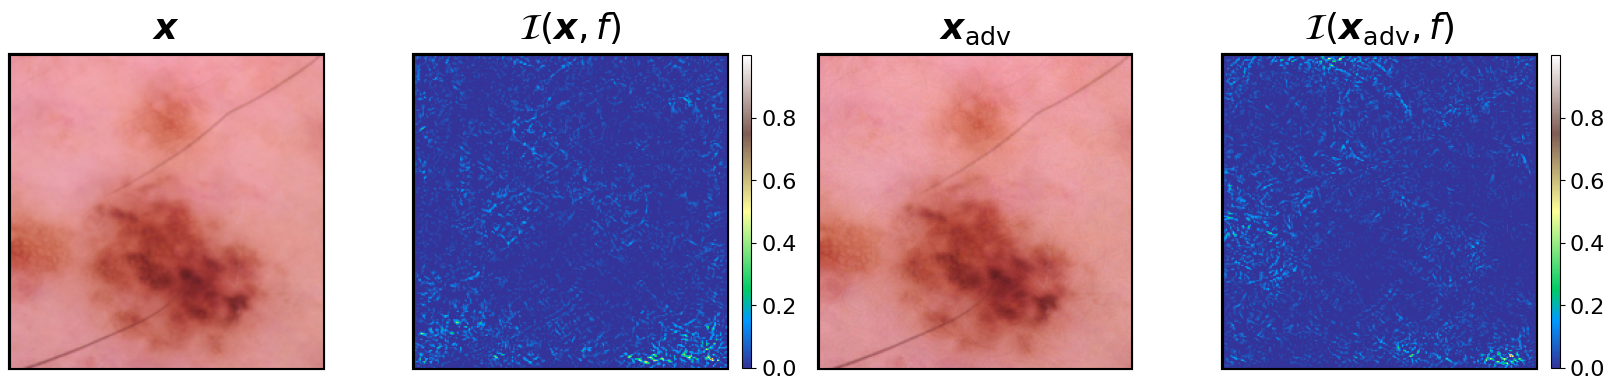

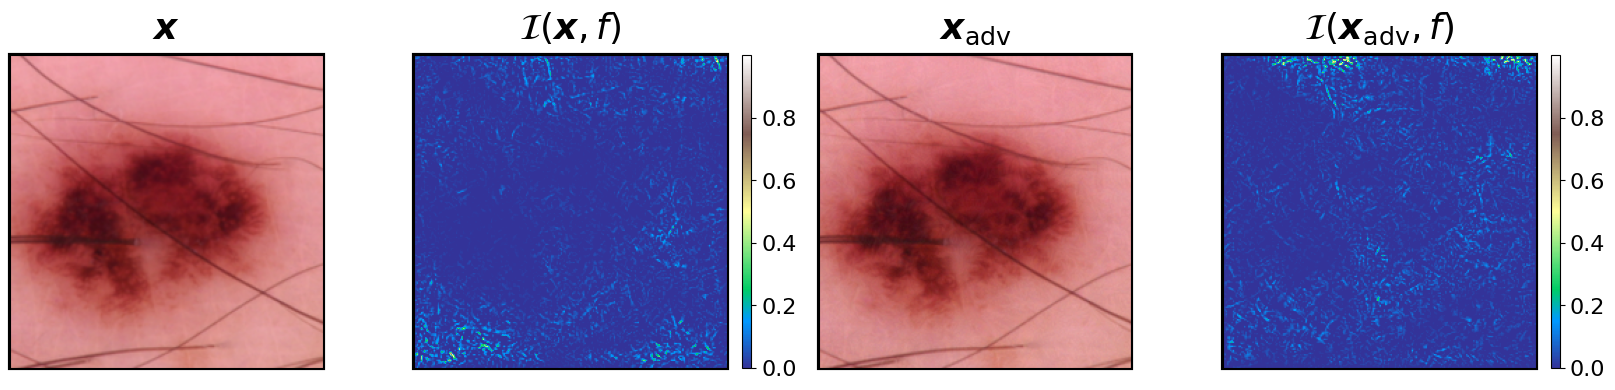

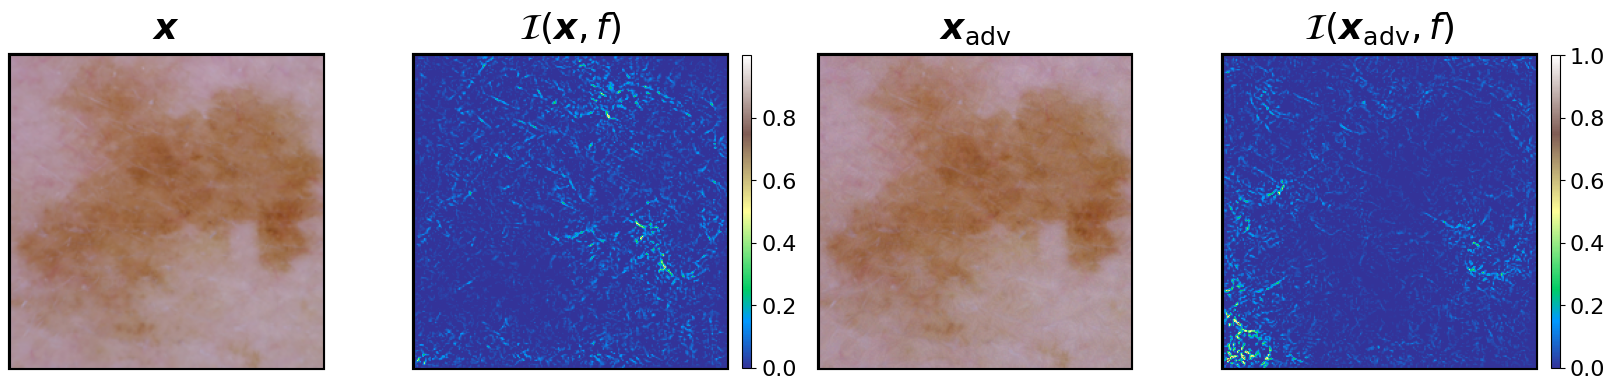

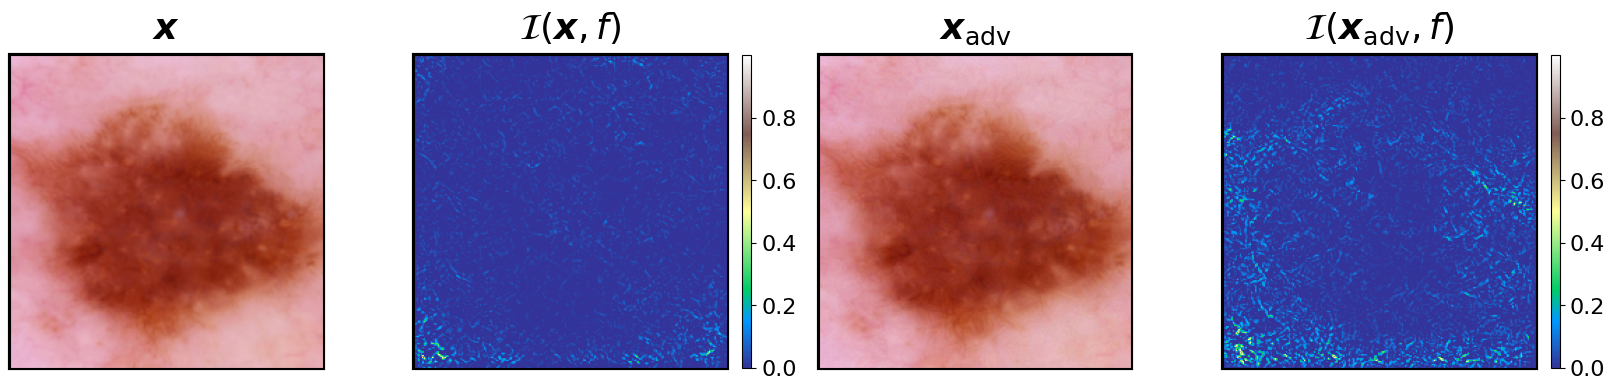

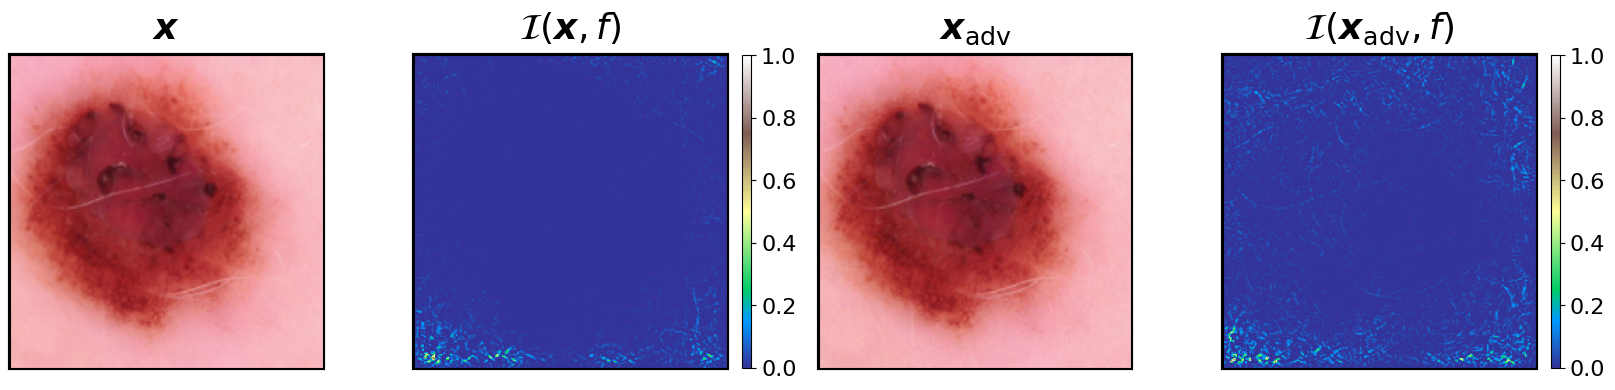

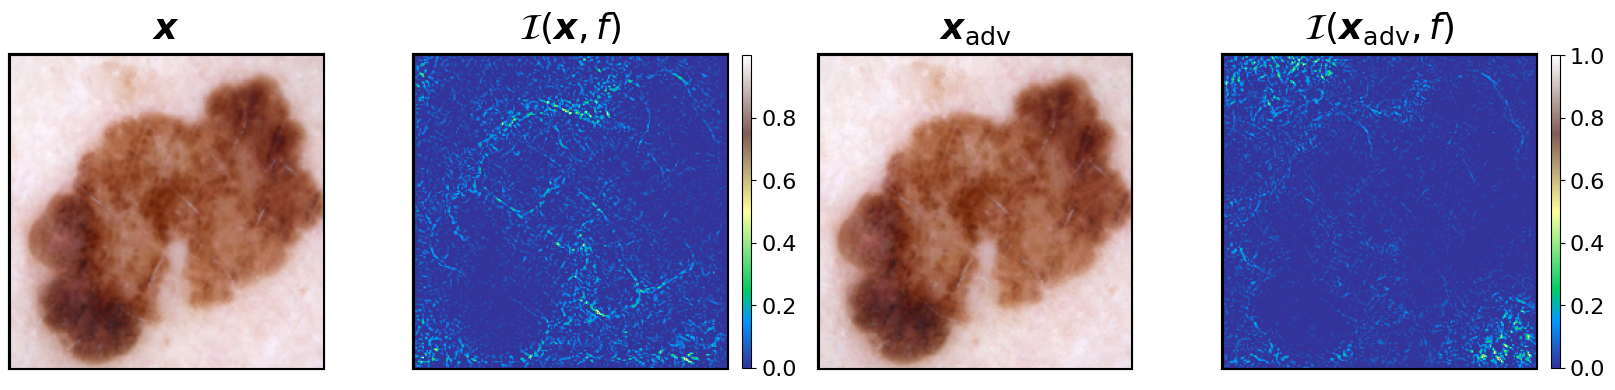

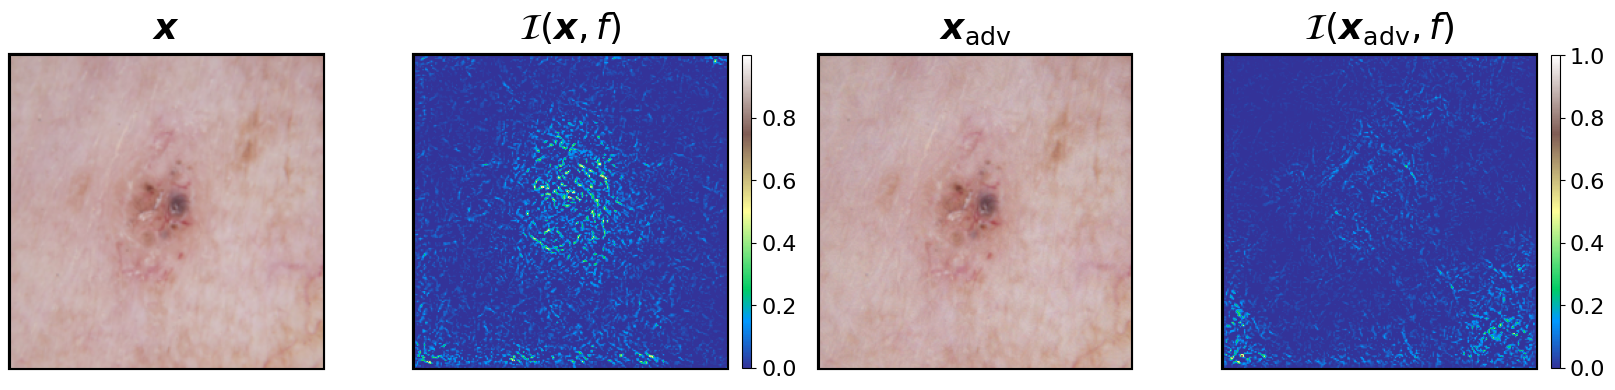

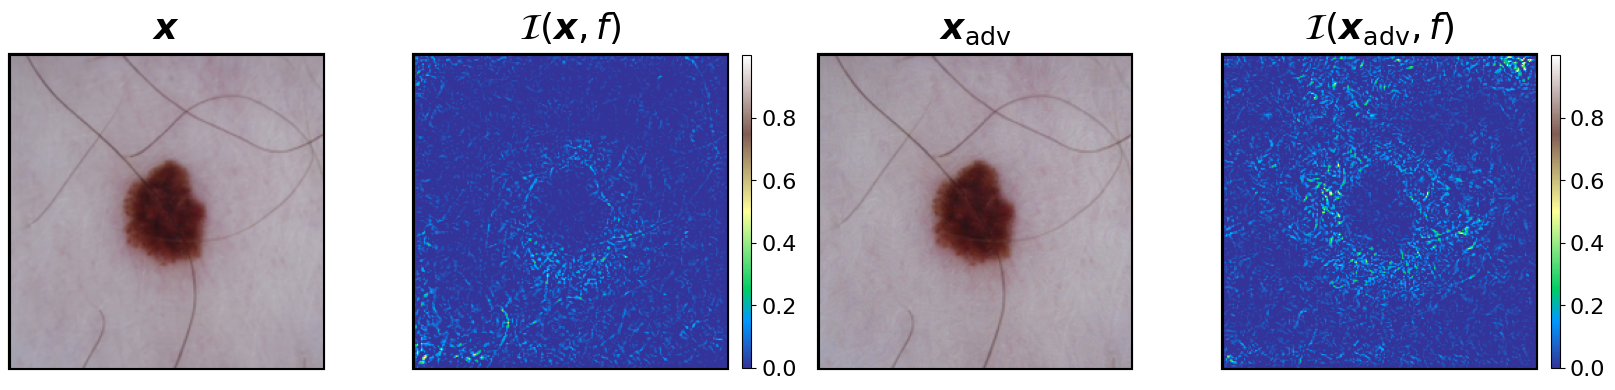

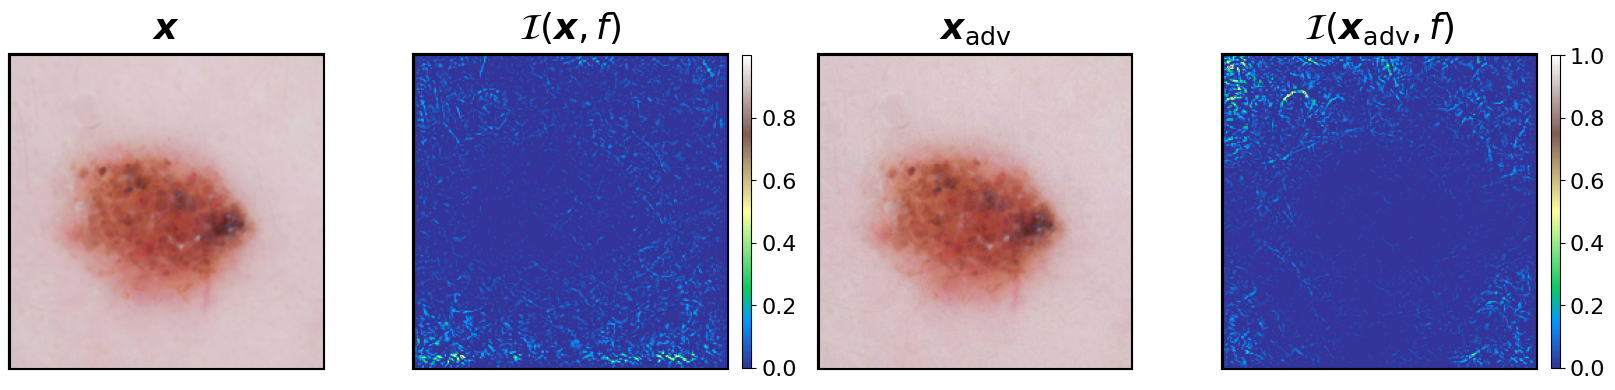

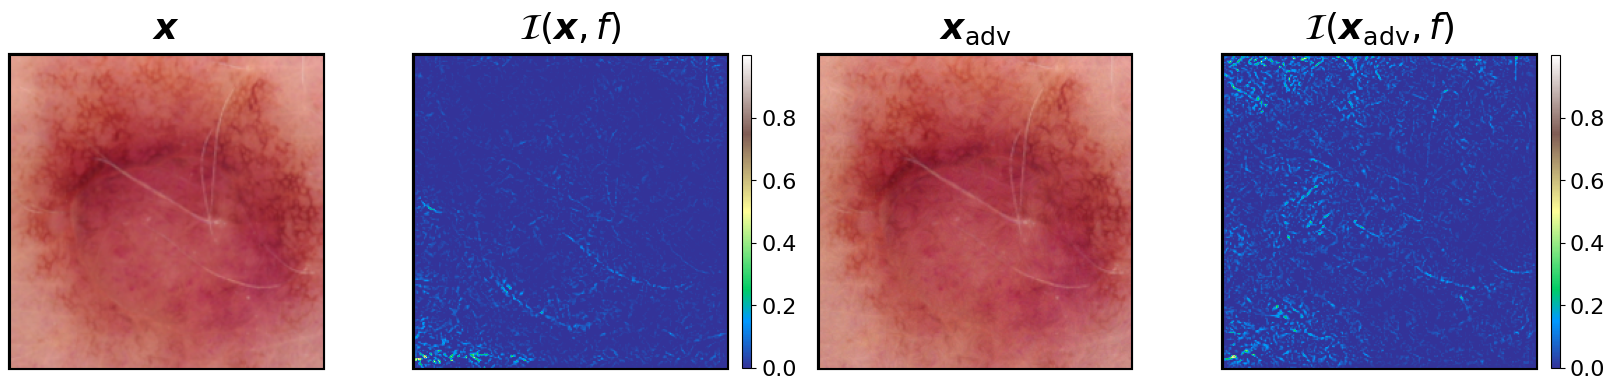

In [12]:

for i, (name, adv) in enumerate(adversarial_examples.items()):
    plot([
        data_clean.__getitem__from_name__(name)[0].numpy().transpose(1, 2, 0),
        attributions_preprocessing(attributions_clean[name], "both","sum","pos",False,True),
        adv.transpose(1, 2, 0),
        adversarial_explanations[name].squeeze()
        ])
        
    plt.show()